### Work through STAC catalog for RCM-ARD

In [1]:
import json
import geopandas as gpd
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt

from pystac_client import Client
import stackstac

In [2]:
# Utility functions
def get_bbox(shp_fp):
    gdf = gpd.read_file(shp_fp)
    if gdf.crs.to_epsg() != 4326:
        gdf = gdf.to_crs(4326)
    bbox = tuple(gdf.total_bounds)

    return bbox

#### Retrieve data within a specific bounding box

In [3]:
# Use City of Ottawa urban boundary as test AOI
shp_fp = './Urban_Boundary.geojson'
aoi_gdf = gpd.read_file(shp_fp)
utm_crs = aoi_gdf.estimate_utm_crs().to_epsg()  # required for stackstac call
bbox = get_bbox(shp_fp)
bbox

(-75.96666401487873, 45.23090774120208, -75.43410167132566, 45.516074722660285)

In [4]:
# Open EODMS STAC catalog and explore available collections
cat_url = 'https://www.eodms-sgdot.nrcan-rncan.gc.ca/stac/'
catalog = Client.open(cat_url)
collections = list(catalog.get_collections())

print(f"Number of collections: {len(collections)}")
print("Collection IDs:")
for collection in collections:
    print(f"- {collection.id}")

Number of collections: 3
Collection IDs:
- sentinel-1
- rcm-ard
- rcm


In [5]:
# Get RCM-CEOS-ARD collection by ID and explore
collection = catalog.get_child('rcm-ard')
collection

<CollectionClient id=rcm-ard>

In [6]:
# List all RCM-ARD items in collection that intersect with area of interest
search = catalog.search(
    collections=["rcm-ard"],
    bbox=bbox
)

items = search.item_collection()
print(f"Returned {len(items)} Items:")
for item in items:
    print(item.properties['title'])

Returned 4 Items:
RCM1_OK2978586_PK3061982_1_SC30MCPC_20240511_225201_CH_CV_MLC
RCM2_OK2603500_PK2843058_1_SC30MCPC_20231123_111136_CH_CV_MLC
RCM2_OK1451009_PK1451245_2_5M12_20200424_111154_HH_HV_SLC
RCM3_OK2017056_PK2017214_1_16MCP3_20200421_224405_CH_CV_SLC


#### Filter and stack results

In [7]:
# Filter results by desired properties: looking for MLC products with 'CH', 'CV', and 'XC' polarizations
polarizations = ['CH', 'CV', 'XC']
product_type = 'MLC'
filtered_items = [x for x in items if x.properties['sar:polarizations'] == polarizations and x.properties['sar:product_type'] == product_type]
for item in filtered_items:
    print(item.properties['title'], item.properties['sar:instrument_mode'])

RCM1_OK2978586_PK3061982_1_SC30MCPC_20240511_225201_CH_CV_MLC Medium Resolution 30m
RCM2_OK2603500_PK2843058_1_SC30MCPC_20231123_111136_CH_CV_MLC Medium Resolution 30m


In [8]:
# Select only specific RCM products for comparison instead of stacking all available from catalog
order_keys = ['RCM1_OK2978586_PK3061982_1_SC30MCPC_20240511_225201_CH_CV_MLC', 'RCM2_OK2603500_PK2843058_1_SC30MCPC_20231123_111136_CH_CV_MLC']
selected_items = [x for x in filtered_items if x.properties['title'] in order_keys]

In [9]:
# Explore assets available in products: contains data rasters in GTiff format along with metadata
selected_items[0].assets

{'RL': <Asset href=https://rcm-ceos-ard.s3.ca-central-1.amazonaws.com/MLC/2024/05/11/RCM1_OK2978586_PK3061982_1_SC30MCPC_20240511_225201_CH_CV_MLC/RCM1_OK2978586_PK3061982_1_SC30MCPC_20240511_225201_RL.tif>,
 'RR': <Asset href=https://rcm-ceos-ard.s3.ca-central-1.amazonaws.com/MLC/2024/05/11/RCM1_OK2978586_PK3061982_1_SC30MCPC_20240511_225201_CH_CV_MLC/RCM1_OK2978586_PK3061982_1_SC30MCPC_20240511_225201_RR.tif>,
 'RRRL': <Asset href=https://rcm-ceos-ard.s3.ca-central-1.amazonaws.com/MLC/2024/05/11/RCM1_OK2978586_PK3061982_1_SC30MCPC_20240511_225201_CH_CV_MLC/RCM1_OK2978586_PK3061982_1_SC30MCPC_20240511_225201_RRRL.tif>,
 'dataMask': <Asset href=https://rcm-ceos-ard.s3.ca-central-1.amazonaws.com/MLC/2024/05/11/RCM1_OK2978586_PK3061982_1_SC30MCPC_20240511_225201_CH_CV_MLC/RCM1_OK2978586_PK3061982_1_SC30MCPC_20240511_225201_bitmask.tif>,
 'metadata': <Asset href=https://rcm-ceos-ard.s3.ca-central-1.amazonaws.com/MLC/2024/05/11/RCM1_OK2978586_PK3061982_1_SC30MCPC_20240511_225201_CH_CV_MLC/

In [10]:
# Stack selected assets into a multi-band xarray DataArray raster with stackstac
stack = stackstac.stack(selected_items,
                        assets=['RR', 'RL'],
                        bounds_latlon=bbox,  # only include pixels within our bounding box
                        resolution=30,
                        epsg=utm_crs
                       )
stack

C:\Users\sleipe\.conda\envs\rcm-stac-env\lib\site-packages\stackstac\prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-0a53e4e2abff673f00256ca2ed836542' (time: 2,
                                                                band: 2,
                                                                y: 1069, x: 1400)> Size: 48MB
dask.array<fetch_raster_window, shape=(2, 2, 1069, 1400), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/34)
  * time                           (time) datetime64[ns] 16B 2023-11-23T11:12...
    id                             (time) <U36 288B 'c10dcb7e-3566-453d-b9f7-...
  * band                           (band) <U2 16B 'RR' 'RL'
  * x                              (x) float64 11kB 4.241e+05 ... 4.661e+05
  * y                              (y) float64 9kB 5.041e+06 ... 5.009e+06
    title                          (band) <U40 320B 'Backscatter Measurements...
    ...                             ...
    sat:absolute_orbit             (time) float64 16B 2.424e+04 2.678e+04
    sat:relative_orbit             (time) int32 8B 112 30
    end_datetime                   (time) <U27 216B '2023-11-23T11:12:28.3309...
    order_key                      (time) <U61 488B 'RCM2_OK2603500_PK2843058...
    processing:software            object 8B {'RCM PGS': '7.06'}
    epsg                           int32 4B 32618
Attributes:
    spec:        RasterSpec(epsg=32618, bounds=(424110, 5008680, 466110, 5040...
    crs:         epsg:32618
    transform:   | 30.00, 0.00, 424110.00|\n| 0.00,-30.00, 5040750.00|\n| 0.0...
    resolution:  30

### Data manipulation with xarray

In [11]:
# Convert raster intensity values to decibels (dB)
stack_db = 10 * np.log10(stack)

In [12]:
# Calculate RR / (RR + RL) as new band for visualization and add to array
rr, rl = stack.sel(band='RR'), stack.sel(band='RL')
rr_rl = rr / (rr + rl)
rr_rl_exp = rr_rl.expand_dims(dim='band', axis=1)
rr_rl_exp.coords['band'] = ['RR / (RR + RL)']
rr_rl_exp = rr_rl_exp.assign_coords(
    title=('band', ['Backscatter Measurements RR / (RR + RL) Polarizations']))

stack_mod = xr.concat([stack_db, rr_rl_exp], dim='band')
stack_mod

<xarray.DataArray 'stackstac-0a53e4e2abff673f00256ca2ed836542' (time: 2,
                                                                band: 3,
                                                                y: 1069, x: 1400)> Size: 72MB
dask.array<concatenate, shape=(2, 3, 1069, 1400), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/34)
  * time                           (time) datetime64[ns] 16B 2023-11-23T11:12...
    id                             (time) <U36 288B 'c10dcb7e-3566-453d-b9f7-...
  * band                           (band) <U14 168B 'RR' 'RL' 'RR / (RR + RL)'
  * x                              (x) float64 11kB 4.241e+05 ... 4.661e+05
  * y                              (y) float64 9kB 5.041e+06 ... 5.009e+06
    title                          (band) <U53 636B 'Backscatter Measurements...
    ...                             ...
    sat:absolute_orbit             (time) float64 16B 2.424e+04 2.678e+04
    sat:relative_orbit             (time) int32 8B 112 30
    end_datetime                   (time) <U27 216B '2023-11-23T11:12:28.3309...
    order_key                      (time) <U61 488B 'RCM2_OK2603500_PK2843058...
    processing:software            object 8B {'RCM PGS': '7.06'}
    epsg                           int32 4B 32618

### Data visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\sleipe\.conda\envs\rcm-stac-env\lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\sleipe\.conda\envs\rcm-stac-env\lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


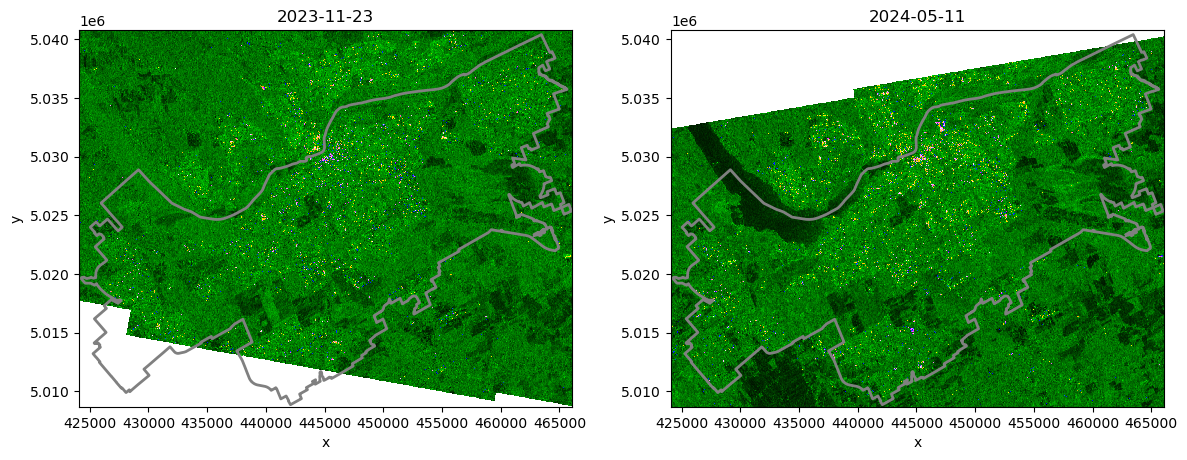

In [13]:
# Compare RGB composite for both scenes: red = RR, green = RR/(RR+RL), blue = RL
# Suggested visualization for compact polarimetric data as per CEOS-ARD standards
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

for i, ax in enumerate(axes):
    stack_mod.isel(time=i, band=[0, 2, 1]).plot.imshow(rgb="band", ax=ax)  # plot raster bands as RGB
    aoi_gdf.to_crs(utm_crs).plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=2) # overlay vector boundary on plot
    ax.set(title=str(stack_mod.isel(time=i).coords['time'].values).split('T')[0])